## CNN with Adam Optimizer and a LR Scheduler
Image Transformations Used:
1. Normalization

Params:
1. Epochs - 30
2. Learning Rate - 0.001

In [1]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.datasets import GTSRB

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import shutil
import os


#------------------------------Only Normalization Preprocessing Step ------------------------------

In [2]:
root_dir = '/root/GTSRB'

os.makedirs(root_dir, exist_ok=True)

# Add normalization to preprocessing
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalize to range [-1, 1]
])

# Load the training dataset
gtsrb_train = GTSRB(root=root_dir, split='train', transform=transform, download=True)

# Load the test dataset
full_test = GTSRB(root=root_dir, split='test', transform=transform, download=True) #Test Dataset but labeled as val in GTSRB V4

#split testing dataset equally into a testing and validation dataset
val_dataset, test_dataset = train_test_split(full_test, test_size=0.5)


print(f'Number of training samples: {len(gtsrb_train)}')
print(f'Number of test samples: {len(test_dataset)}')
print(f'Number of test samples: {len(val_dataset)}')

Number of training samples: 26640
Number of test samples: 6315
Number of test samples: 6315


#-------------------------------------------------------------------------------------------------------------------------

In [3]:
train_loader = torch.utils.data.DataLoader(gtsrb_train, batch_size=64, shuffle=True, num_workers=4, drop_last=True) # train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, drop_last=True)  # val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, drop_last=True)  # val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, drop_last=True)

image, label = gtsrb_train[12]
print(image.shape)
print(label)

torch.Size([3, 32, 32])
0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [4]:
#CNN Model
class CNNNets(nn.Module):
    def __init__(self, modelname, channels):
        super(CNNNets, self).__init__()

        # Define the convolutional layers
        # ((pixelSize - kernelSize ) / Stride ) + 1 = new image size

        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=32, kernel_size=3) #results in 32 channels of 30x30 pxl images
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #results in 32 channels of 15x15 pxl images
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3) #results in 64 channels of 13x13 pxl images
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)#Is pooled a second time to become 64 channels of 6x6 images
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3) #results in 128 channels of 4x4 pxl images
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)#Is pooled a second time to become 128 channels of 2x2 images

        # Define the fully connected layers
        self.fc1 = nn.Linear(in_features=128*2*2, out_features=120) #input the second pooled image
        self.fc2 = nn.Linear(in_features=120, out_features=84) # intermediate linear layer
        self.out = nn.Linear(in_features=84, out_features=43)  # Assuming 43 classes for classification

        self.train_losses = []
        self.val_losses = []
        self.train_accuracy = []
        self.test_accuracy = None
        self.all_predictions = None
        self.all_labels = None
        self.y_true = None
        self.y_pred = None
        self.modelname = modelname


    def forward(self, x):
        # Apply the first convolutional layer, followed by max pooling
        x = self.pool1(torch.relu(self.conv1(x)))
        # Apply the second convolutional layer, followed by max pooling
        x = self.pool2(torch.relu(self.conv2(x)))
        # Apply the third convolutional layer, followed by max pooling
        x = self.pool3(torch.relu(self.conv3(x)))
        # Flatten the output of the last convolutional layer for the fully connected layers
        x = torch.flatten(x, 1)

        # Apply the fully connected layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        # Output layer (class predictions)
        x = self.out(x)
        return x

    def train_model(self, model, train_loader, val_loader, num_epochs=30):
      # utilizing GPU while training the model
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      model = model.to(device)


      # Initializing the Cross Entropy Loss and Adam Optimizer
      learning_rate = 0.001
      decay_rate = learning_rate / num_epochs
      criterion = nn.CrossEntropyLoss()
      optimizer = optim.NAdam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-8, weight_decay=decay_rate)
      #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

      best_val_acc = 0.0
      self.train_losses = []
      self.val_losses = []
      self.val_accuracy = []

      # running the model for 30 epochs
      for epoch in range(num_epochs):
          model.train()
          running_loss = 0.0
          correct = 0
          total = 0
          self.y_true = []
          self.y_pred = []

          # Training
          for inputs, labels in train_loader:
              inputs, labels = inputs.to(device), labels.to(device)
              optimizer.zero_grad()
              outputs = model(inputs)
              loss = criterion(outputs, labels)
              loss.backward()
              optimizer.step()

              running_loss += loss.item()
              _, predicted = outputs.max(1)
              self.y_true.extend(labels.cpu().numpy())
              self.y_pred.extend(predicted.cpu().numpy())
              total += labels.size(0)
              correct += predicted.eq(labels).sum().item()

          epoch_loss = running_loss / len(train_loader)
          self.train_losses.append(epoch_loss) #Save current epoch loss value


          # Validation/Testing
          val_loss = 0.0
          val_correct = 0
          val_total = 0
          model.eval()

          with torch.no_grad():
              for inputs, labels in val_loader:
                  inputs, labels = inputs.to(device), labels.to(device)
                  outputs = model(inputs)
                  loss = criterion(outputs, labels)

                  val_loss += loss.item()
                  _, predicted = outputs.max(1)
                  val_total += labels.size(0)
                  val_correct += predicted.eq(labels).sum().item()

          train_acc = 100. * correct / total
          val_acc = 100. * val_correct / val_total

          self.train_accuracy.append(train_acc) #Save current epoch training accuracy
          self.val_losses.append(val_loss / len(val_loader)) #Save current epoch validation loss
          self.val_accuracy.append(val_acc) #Save current epoch validation accuracy

          # Saving the best model
          if val_acc > best_val_acc:
              best_val_acc = val_acc
              torch.save(model.state_dict(), 'best_' + self.modelname + '.pth')

          print(f'Epoch [{epoch+1}/{num_epochs}]')
          print(f'Training Loss: {running_loss/len(train_loader):.3f}')
          print(f'Training Accuracy: {train_acc:.2f}%')
          print(f'Validation Accuracy: {val_acc:.2f}%')
          print(f'Best Validation Accuracy: {best_val_acc:.2f}%')
          print('--------------------')

    def testModels(self, modelname, num_epochs=30):
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.to(device) # Move the model to the device using self
      self.load_state_dict(torch.load('best_' + self.modelname + '.pth'))

      learning_rate = 0.001
      decay_rate = learning_rate / num_epochs
      criterion = nn.CrossEntropyLoss()
      optimizer = optim.NAdam(self.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-8, weight_decay=decay_rate)
      # Testing phase
      self.all_predictions = []
      self.all_labels = []
      test_correct = 0
      test_loss = 0.0
      test_total = 0
      test_acc = 0.0

      with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = self(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

            # Store predictions and labels for metrics calculation
            self.all_predictions.extend(predicted.cpu().numpy())
            self.all_labels.extend(labels.cpu().numpy())

    def displayPlots(self):
      # Display all tables and information:
      epochPlot = range(1, len(self.train_losses) + 1)

      fig, (loss, accuracy) = plt.subplots(1, 2, figsize=(15, 5))

      # Plot training loss
      loss.plot(epochPlot, self.train_losses, label='Training Loss')
      loss.plot(epochPlot, self.val_losses, label='Validation Loss')
      loss.set_xlabel('Epoch')
      loss.set_ylabel('Loss')
      loss.set_title('Loss vs. Epoch')
      loss.legend()
      loss.grid(True)

      # Plot test accuracy
      accuracy.plot(epochPlot, self.train_accuracy, label='Training Accuracy')
      accuracy.plot(epochPlot, self.val_accuracy, label='Validation Accuracy')
      accuracy.set_xlabel('Epoch')
      accuracy.set_ylabel('Accuracy (%)')
      accuracy.set_title('Accuracy vs. Epoch')
      accuracy.legend()
      accuracy.grid(True)
      plt.show()

    def confusionMatrix(self):
      cm = confusion_matrix(self.y_true, self.y_pred)
      # Plot the confusion matrix
      fig, ax = plt.subplots(figsize=(10,10))
      im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
      ax.figure.colorbar(im, ax=ax)

      # We want to show all ticks...
      ax.set(xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            xticklabels=np.arange(43), # Assuming 43 classes
            yticklabels=np.arange(43),
            title='Confusion Matrix',
            ylabel='True label',
            xlabel='Predicted label')

      # Rotate the tick labels and set their alignment.
      plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
              rotation_mode="anchor")

      # Loop over data dimensions and create text annotations.
      fmt = 'd'
      thresh = cm.max() / 2.
      for i in range(cm.shape[0]):
          for j in range(cm.shape[1]):
              ax.text(j, i, format(cm[i, j], fmt),
                      ha="center", va="center",
                      color="white" if cm[i, j] > thresh else "black")
      fig.tight_layout()
      plt.show()

    def displayValues(self): #Prints the important metrics of the model (accuracy, precision, recall, f1)
      accuracy = accuracy_score(self.all_labels, self.all_predictions)
      precision = precision_score(self.all_labels, self.all_predictions, average='macro')  # Use 'macro' for multi-class
      recall = recall_score(self.all_labels, self.all_predictions, average='macro')
      f1 = f1_score(self.all_labels, self.all_predictions, average='macro')
      print("")
      print(f"Accuracy: {accuracy}")
      print(f"Precision: {precision}")
      print(f"Recall: {recall}")
      print(f"F1-score: {f1}")
      print("")


In [5]:
train_loader = torch.utils.data.DataLoader(gtsrb_train, batch_size=64, shuffle=True, num_workers=4, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, drop_last=True)
Normalized = CNNNets("Normalized", 3) # 3 in channels (RGB), 32x32 pixel images

In [6]:
Normalized.train_model(Normalized, train_loader, val_loader)

Epoch [1/30]
Training Loss: 2.118
Training Accuracy: 36.51%
Validation Accuracy: 59.10%
Best Validation Accuracy: 59.10%
--------------------
Epoch [2/30]
Training Loss: 0.552
Training Accuracy: 82.46%
Validation Accuracy: 78.97%
Best Validation Accuracy: 78.97%
--------------------
Epoch [3/30]
Training Loss: 0.182
Training Accuracy: 94.82%
Validation Accuracy: 85.75%
Best Validation Accuracy: 85.75%
--------------------
Epoch [4/30]
Training Loss: 0.091
Training Accuracy: 97.46%
Validation Accuracy: 88.19%
Best Validation Accuracy: 88.19%
--------------------
Epoch [5/30]
Training Loss: 0.053
Training Accuracy: 98.50%
Validation Accuracy: 88.93%
Best Validation Accuracy: 88.93%
--------------------
Epoch [6/30]
Training Loss: 0.043
Training Accuracy: 98.85%
Validation Accuracy: 89.01%
Best Validation Accuracy: 89.01%
--------------------
Epoch [7/30]
Training Loss: 0.028
Training Accuracy: 99.22%
Validation Accuracy: 89.51%
Best Validation Accuracy: 89.51%
--------------------
Epoch 

In [7]:
Normalized.testModels("Normalized")

<ipython-input-4-2f0cbb5ee96a>:136: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load('best_' + self.modelname + '.pth'))


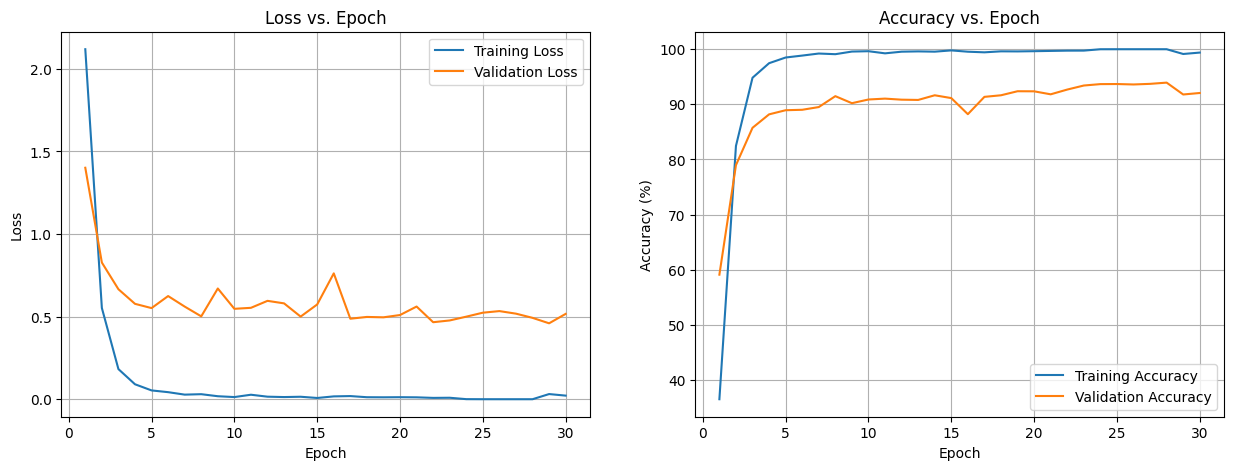

In [8]:
Normalized.displayPlots()

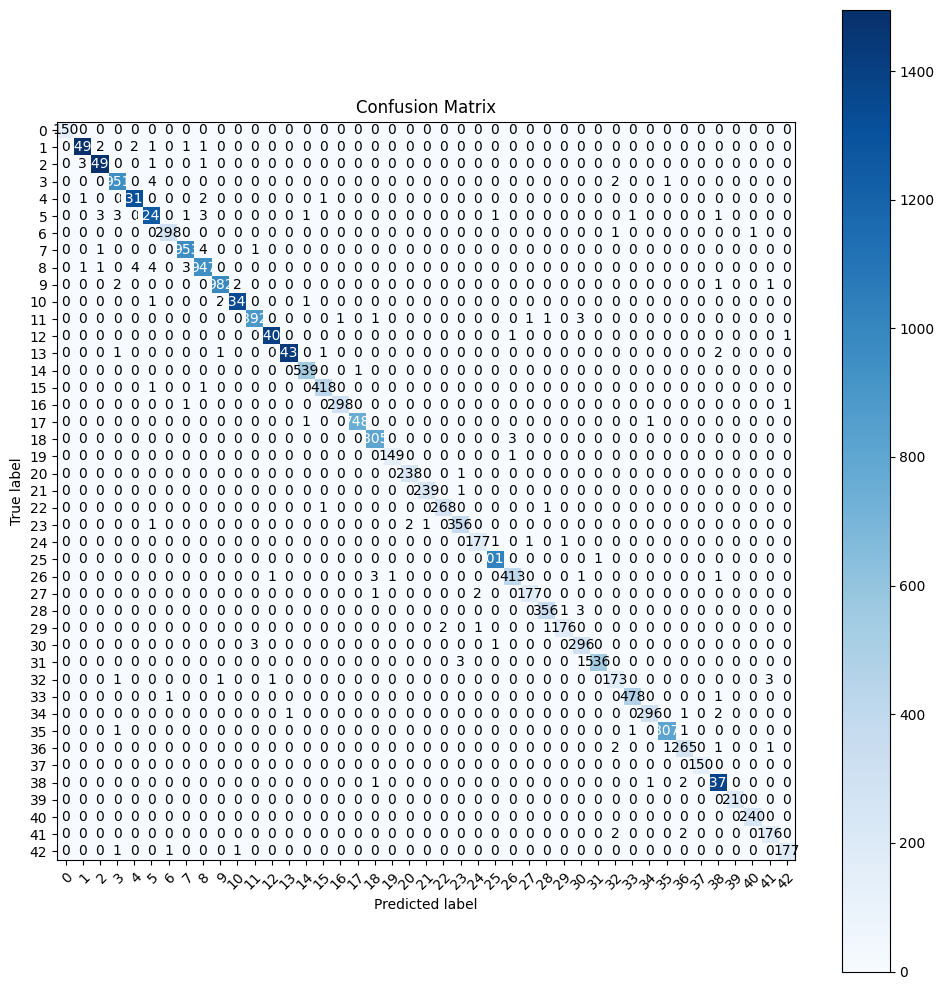

In [9]:
Normalized.confusionMatrix()

In [10]:
Normalized.displayValues()


Accuracy: 0.9408482142857143
Precision: 0.9154664035779497
Recall: 0.907092710752155
F1-score: 0.9061258750812812



#-----------------------------------Transformation Process-----------------------------------

For any transformations change the "transform =" formula, then run the CNNets commands: .main, .displayPlots, .confusionMatrix, .displayValues


.main : Runs the training process. Prints training loss, accuracy and validation accuracy values during each epoch. Make sure to run this first.


.displayPlots : displays the Training Loss Vs Epoch and Val Accuracy Vs Epoch Plots


.confusionMatrix : self explanatory. Prints out the confusion matrix


.displayValues : prints out the accuracy, precision, F1, and Recall of the model


Current models expects 32x32 image and 3 channels

##--------------------------------------Set 1: {CLAHE, Cropping, Grayscale, Sharpening}  -----------------------------

In [11]:
#root_dir = '/root/GTSRB'
#os.makedirs(root_dir, exist_ok=True)
#^^^^^ Not needed if ran code from the beginning ^^^^^^

#********************************************************************************
#                           Change me!
#vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
# Add CLAHE preprocessing
import cv2

# Add CLAHE preprocessing
def clahe_preprocess(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(image)  # Apply CLAHE
    return np.stack([enhanced_image] * 3, axis=-1)  # Convert back to 3-channel

# Image transforms while downloaing the dataset
train_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.CenterCrop(28),
    transforms.RandomRotation(10),
    # transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Lambda(lambda img: torch.tensor(clahe_preprocess(np.array(img)), dtype=torch.float32).permute(2, 0, 1)),
    transforms.Normalize((0.3337, 0.3064, 0.3171), (0.2672, 0.2564, 0.2629))
])

in_channels = 3 #Number of in channels 3 for rgb, 1 for grayscale. Assuming 32x32 pixel image

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#                           Change me!
#********************************************************************************

gtsrb_train = GTSRB(root=root_dir, split='train', transform=transform, download=True) # Load the training dataset
full_test = GTSRB(root=root_dir, split='test', transform=transform, download=True) # Load the test dataset
val_dataset, test_dataset = train_test_split(full_test, test_size=0.5) #split testing dataset equally into a testing and validation dataset

train_loader = torch.utils.data.DataLoader(gtsrb_train, batch_size=64, shuffle=True, num_workers=4, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, drop_last=True)


Clahe = CNNNets("Clahe", in_channels) #Use a model Name based on the transform set used. Format: Model Name, In Channels
Clahe.train_model(Clahe, train_loader, val_loader)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/30]
Training Loss: 2.250
Training Accuracy: 34.30%
Validation Accuracy: 58.85%
Best Validation Accuracy: 58.85%
--------------------
Epoch [2/30]
Training Loss: 0.560
Training Accuracy: 81.94%
Validation Accuracy: 80.18%
Best Validation Accuracy: 80.18%
--------------------
Epoch [3/30]
Training Loss: 0.196
Training Accuracy: 94.12%
Validation Accuracy: 85.27%
Best Validation Accuracy: 85.27%
--------------------
Epoch [4/30]
Training Loss: 0.104
Training Accuracy: 96.88%
Validation Accuracy: 88.19%
Best Validation Accuracy: 88.19%
--------------------
Epoch [5/30]
Training Loss: 0.065
Training Accuracy: 98.15%
Validation Accuracy: 89.14%
Best Validation Accuracy: 89.14%
--------------------
Epoch [6/30]
Training Loss: 0.050
Training Accuracy: 98.56%
Validation Accuracy: 89.84%
Best Validation Accuracy: 89.84%
--------------------
Epoch [7/30]
Training Loss: 0.037
Training Accuracy: 98.99%
Validation Accuracy: 89.76%
Best Validation Accuracy: 89.84%
--------------------
Epoch 

In [12]:
Clahe.testModels("Clahe")

<ipython-input-4-2f0cbb5ee96a>:136: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load('best_' + self.modelname + '.pth'))


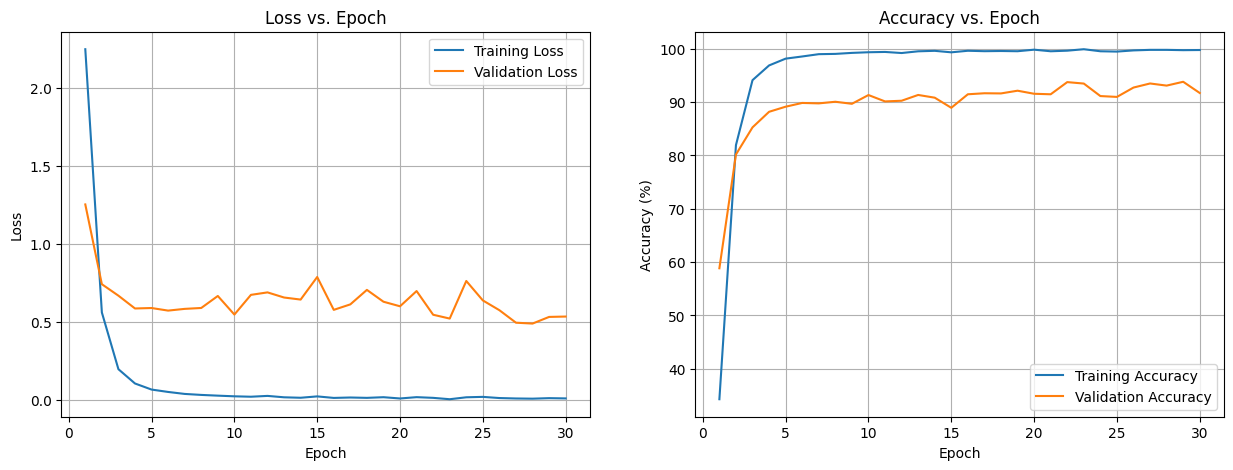

In [13]:
Clahe.displayPlots()

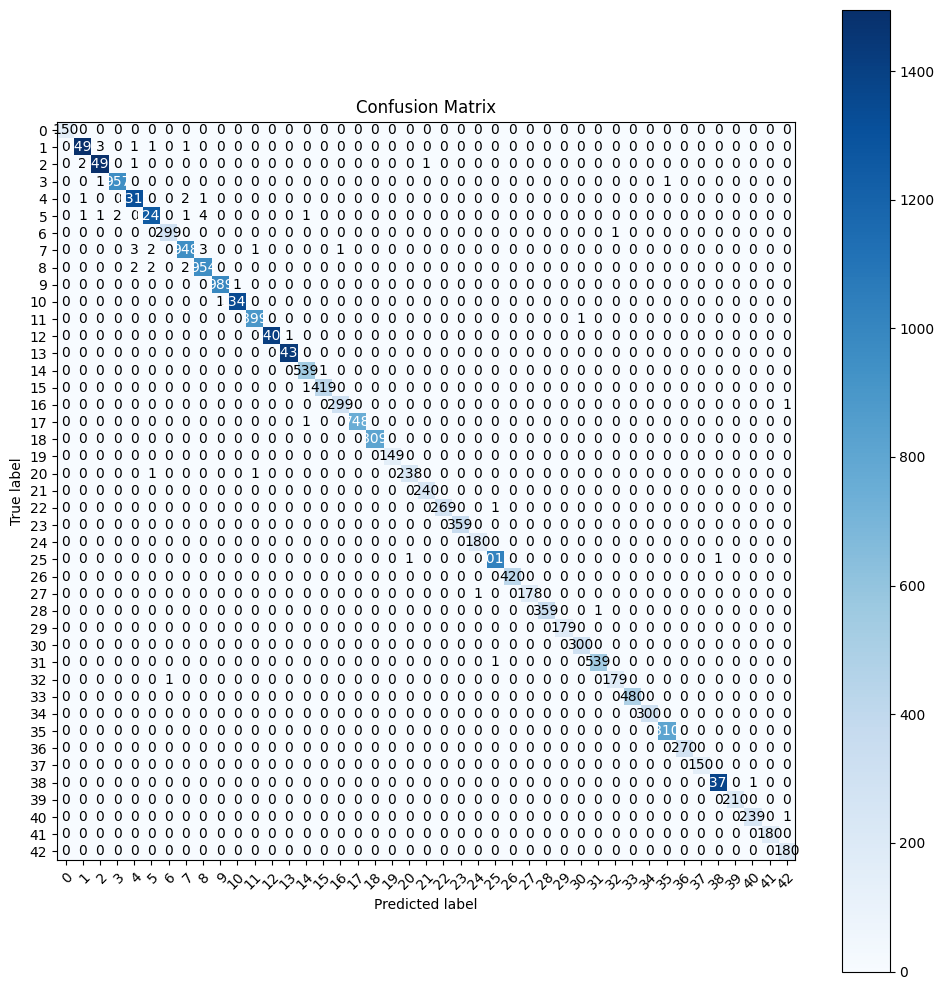

In [14]:
Clahe.confusionMatrix()

In [15]:
Clahe.displayValues()


Accuracy: 0.9339923469387755
Precision: 0.9060413147994714
Recall: 0.8945932121791549
F1-score: 0.8903259502465888



##-------------------------------Set 2: {Rotation,Center Crop,Random Affiner,Color Jitter}	 -------------------------


In [16]:
#root_dir = '/root/GTSRB'
#os.makedirs(root_dir, exist_ok=True)
#^^^^^ Not needed if ran code from the beginning ^^^^^^

#********************************************************************************
#                           Change me!
#vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv


transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.CenterCrop(28),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), (0.2672, 0.2564, 0.2629))
])

in_channels = 3 #Number of in channels 3 for rgb, 1 for grayscale. Assuming 32x32 pixel image

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#                           Change me!
#********************************************************************************

gtsrb_train = GTSRB(root=root_dir, split='train', transform=transform, download=True) # Load the training dataset
full_test = GTSRB(root=root_dir, split='test', transform=transform, download=True) # Load the test dataset
val_dataset, test_dataset = train_test_split(full_test, test_size=0.5) #split testing dataset equally into a testing and validation dataset

train_loader = torch.utils.data.DataLoader(gtsrb_train, batch_size=64, shuffle=True, num_workers=4, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, drop_last=True)


colorJitter = CNNNets("colorJitter", in_channels) #Use a model Name based on the transform set used. Format: Model Name, In Channels
colorJitter.train_model(colorJitter, train_loader, val_loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/30]
Training Loss: 2.293
Training Accuracy: 32.34%
Validation Accuracy: 53.59%
Best Validation Accuracy: 53.59%
--------------------
Epoch [2/30]
Training Loss: 0.714
Training Accuracy: 77.18%
Validation Accuracy: 80.79%
Best Validation Accuracy: 80.79%
--------------------
Epoch [3/30]
Training Loss: 0.232
Training Accuracy: 92.86%
Validation Accuracy: 85.71%
Best Validation Accuracy: 85.71%
--------------------
Epoch [4/30]
Training Loss: 0.113
Training Accuracy: 96.84%
Validation Accuracy: 87.44%
Best Validation Accuracy: 87.44%
--------------------
Epoch [5/30]
Training Loss: 0.066
Training Accuracy: 98.16%
Validation Accuracy: 87.80%
Best Validation Accuracy: 87.80%
--------------------
Epoch [6/30]
Training Loss: 0.045
Training Accuracy: 98.68%
Validation Accuracy: 87.88%
Best Validation Accuracy: 87.88%
--------------------
Epoch [7/30]
Training Loss: 0.035
Training Accuracy: 99.02%
Validation Accuracy: 89.09%
Best Validation Accuracy: 89.09%
--------------------
Epoch 

In [17]:
colorJitter.testModels("colorJitter")

<ipython-input-4-2f0cbb5ee96a>:136: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load('best_' + self.modelname + '.pth'))


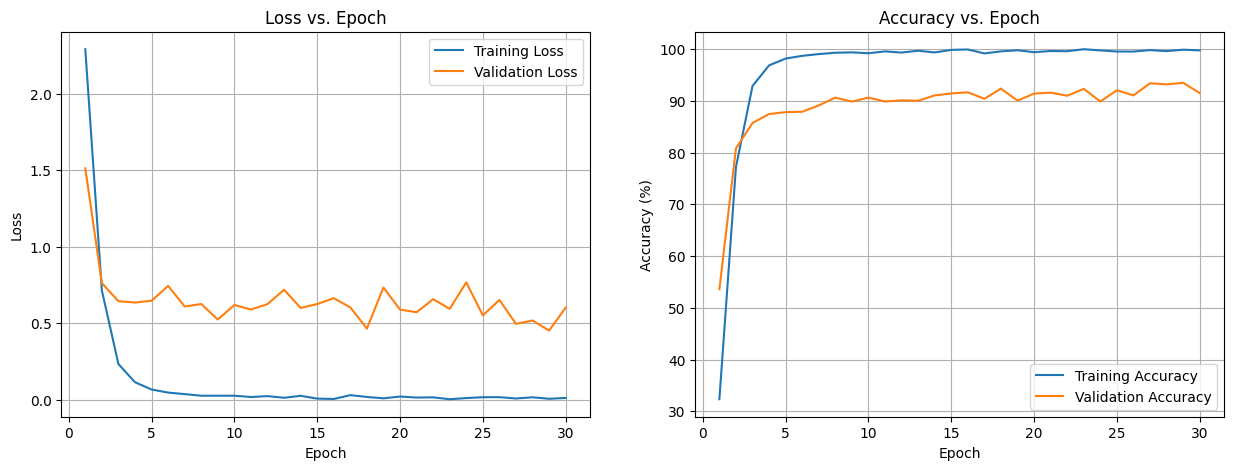

In [18]:
colorJitter.displayPlots()

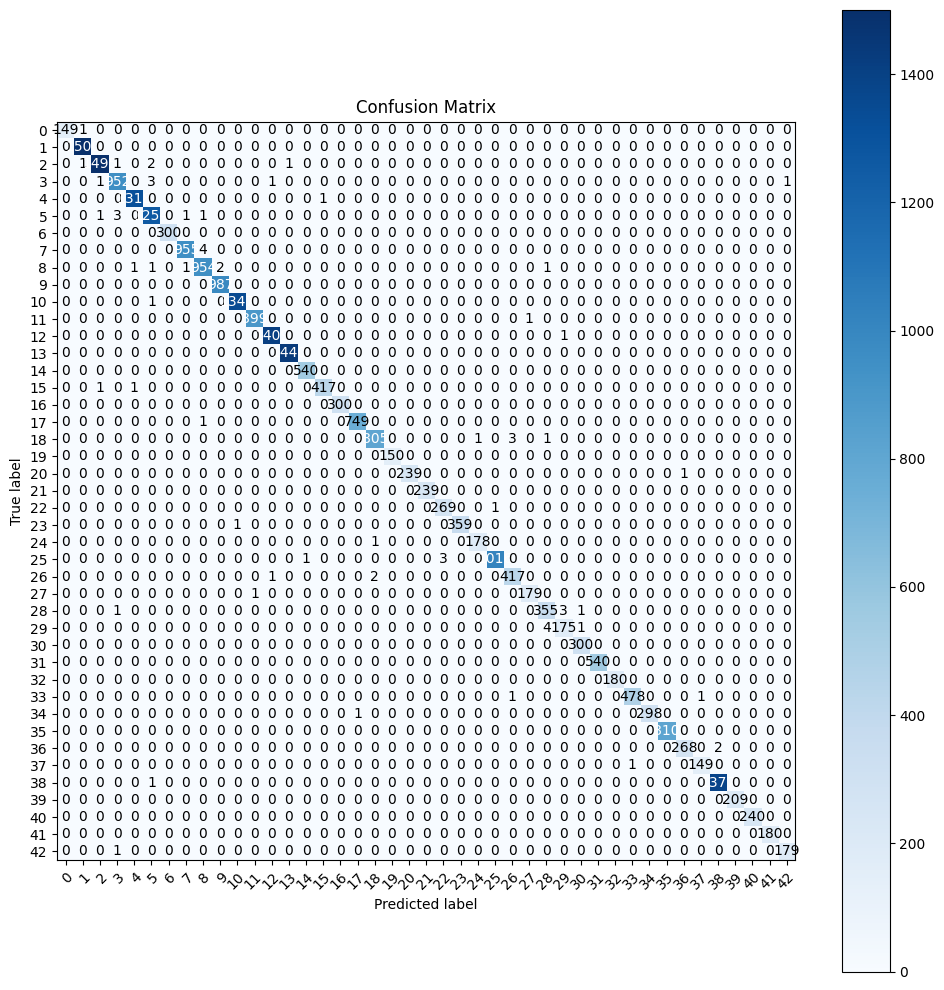

In [19]:
colorJitter.confusionMatrix()

In [20]:
colorJitter.displayValues()


Accuracy: 0.9349489795918368
Precision: 0.9017301692888094
Recall: 0.9004073923003787
F1-score: 0.898242822244566

